# Learning a LJ potential

This notebook showcases the usage of PiNN with a toy problem of learning a Lennard-Jones
potential with a hand-generated dataset.  
It serves as a basic test, and demonstration of the workflow with PiNN.

In [1]:
%matplotlib inline

In [3]:
import os, warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ase import Atoms
from ase.calculators.lj import LennardJones
os.environ['CUDA_VISIBLE_DEVICES'] = ''
index_warning = 'Converting sparse IndexedSlices'
warnings.filterwarnings('ignore', index_warning)

## Reference data

In [4]:
# Helper function: get the position given PES dimension(s)
def three_body_sample(atoms, a, r):
    x = a * np.pi / 180
    pos = [[0, 0, 0],
           [0, 2, 0],
           [0, r*np.cos(x), r*np.sin(x)]]
    atoms.set_positions(pos)
    return atoms

In [5]:
atoms = Atoms('H3', calculator=LennardJones())

na, nr = 50, 50
arange = np.linspace(30,180,na)
rrange = np.linspace(1,3,nr)

# Truth
agrid, rgrid = np.meshgrid(arange, rrange)
egrid = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        atoms = three_body_sample(atoms, arange[i], rrange[j])
        egrid[i,j] = atoms.get_potential_energy()
        
# Samples
nsample = 100
asample, rsample = [], []
distsample = []
data = {'e_data':[], 'f_data':[], 'elems':[], 'coord':[]}
for i in range(nsample):
    a, r = np.random.choice(arange), np.random.choice(rrange)
    atoms = three_body_sample(atoms, a, r)
    dist = atoms.get_all_distances()
    dist = dist[np.nonzero(dist)]
    data['e_data'].append(atoms.get_potential_energy())
    data['f_data'].append(atoms.get_forces())
    data['coord'].append(atoms.get_positions())
    data['elems'].append(atoms.numbers)
    asample.append(a)
    rsample.append(r)
    distsample.append(dist)

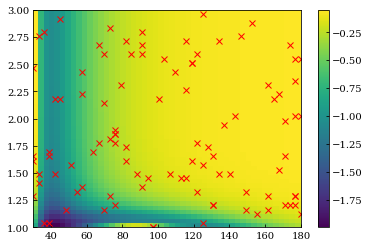

In [6]:
plt.pcolormesh(agrid, rgrid, egrid)
plt.plot(asample, rsample, 'rx')
plt.colorbar()

## Dataset from numpy arrays

In [7]:
from pinn.models import potential_model
from pinn.networks import pinet
from pinn.io import sparse_batch, load_numpy
from pinn.calculator import PiNN_calc

In [8]:
data = {k:np.array(v) for k,v in data.items()}
dataset = lambda: load_numpy(data)

train = lambda: dataset()['train'].shuffle(100).repeat().apply(sparse_batch(100))
test = lambda: dataset()['test'].repeat().apply(sparse_batch(100))

## Training

### Model specification

In [9]:
params={
    'model_dir': '/tmp/PiNet',
    'network': {
        'name': 'PiNet',
        'params': {
            'ii_nodes':[8,8],
            'pi_nodes':[8,8],
            'pp_nodes':[8,8],
            'out_nodes':[8,8],
            'depth': 4,
            'rc': 3.0,
            'atom_types':[1]}},
    'model':{
        'name': 'potential_model',
        'params': {
            'e_dress': {1:-0.3},  # element-specific energy dress
            'e_scale': 2, # energy scale for prediction
            'e_unit': 1.0,  # output unit of energy dur
            'log_e_per_atom': True, # log e_per_atom and its distribution    
            'use_force': True}}}      # include force in Loss function
model = potential_model(params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/PiNet', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
%rm -rf /tmp/PiNet
train_spec = tf.estimator.TrainSpec(input_fn=train, max_steps=5e3)
eval_spec = tf.estimator.EvalSpec(input_fn=test, steps=10)
tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
3144 trainable vaiabless, training with float32 precision.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/Pi

({'METRICS/E_LOSS': 2.4596975e-05,
  'METRICS/E_MAE': 0.0038156472,
  'METRICS/E_PER_ATOM_MAE': 0.0012718836,
  'METRICS/E_PER_ATOM_RMSE': 0.0016531788,
  'METRICS/E_RMSE': 0.004959534,
  'METRICS/F_LOSS': 0.0056514735,
  'METRICS/F_MAE': 0.031843703,
  'METRICS/F_RMSE': 0.07517628,
  'loss': 0.005676071,
  'global_step': 5000},
 [])

## Validate the results
### PES analysis

In [11]:
atoms = Atoms('H3', calculator=PiNN_calc(model))
epred = np.zeros([na, nr])
for i in range(na):
    for j in range(nr):
        a, r = arange[i], rrange[j]
        atoms = three_body_sample(atoms, a, r)
        epred[i,j] = atoms.get_potential_energy()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/PiNet/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


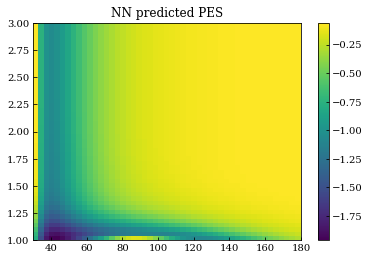

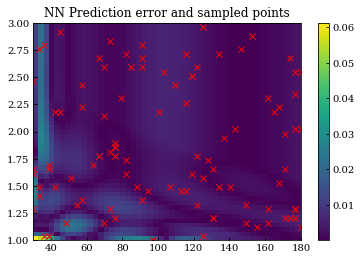

In [12]:
plt.pcolormesh(agrid, rgrid, epred)
plt.colorbar()
plt.title('NN predicted PES')
plt.figure()
plt.pcolormesh(agrid, rgrid, np.abs(egrid-epred))
plt.plot(asample, rsample, 'rx')
plt.title('NN Prediction error and sampled points')
plt.colorbar()

### Pairwise potential analysis

In [13]:
atoms1 = Atoms('H2', calculator=PiNN_calc(model))
atoms2 = Atoms('H2', calculator=LennardJones())

nr2 = 100
rrange2 = np.linspace(1,1.9,nr2)
epred = np.zeros(nr2)
etrue = np.zeros(nr2)

for i in range(nr2):
    pos = [[0, 0, 0],
           [rrange2[i], 0, 0]]
    atoms1.set_positions(pos)
    atoms2.set_positions(pos)
    epred[i] = atoms1.get_potential_energy()
    etrue[i] = atoms2.get_potential_energy()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/PiNet/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


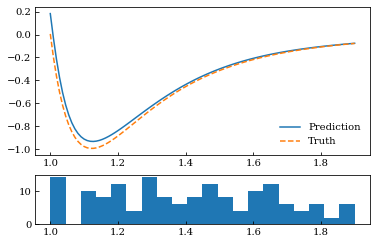

In [14]:
f, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.plot(rrange2, epred)
ax1.plot(rrange2, etrue,'--')
ax1.legend(['Prediction', 'Truth'], loc=4)
_=ax2.hist(np.concatenate(distsample,0), 20, range=(1,1.9))

## Molecular dynamics with ASE

In [15]:
from ase import units
from ase.io import Trajectory
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [ ]:
atoms = Atoms('H', cell=[2, 2, 2], pbc=True)
atoms = atoms.repeat([5,5,5])
atoms.rattle()
atoms.set_calculator(PiNN_calc(model))
MaxwellBoltzmannDistribution(atoms, 300*units.kB)
dyn = NVTBerendsen(atoms, 0.5 * units.fs, 300, taut=0.5*100*units.fs)
dyn.attach(Trajectory('ase_nvt.traj', 'w', atoms).write, interval=10)
dyn.run(5000)